<a href="https://colab.research.google.com/github/natalialopezg/Monografia-EACD/blob/master/Polyp_Segmentation_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="polyp-segmentationt"></a>
# Polyp Segmentation

<a name="objectives"></a>
## Objective
In the previous notebook, we have explored the polyp images and masks, as well as preprocessing and split data into train, validation, and test set.


## Table of contents
  * [Polyp Segmentation](#polyp-segmentation)
    * [Objective](#objectives)
    * [Table of Contents](#table-of-contents)
    * [Library import](#library-import)
    * [Load data](#load-data)
    * [Functions definition](#functions-definition)
    * [Classes and methods definition](#classes-methods-definition)
    * [Variational Autoencoder Model](#vae-model)
      * [Model configuration](#model-configuration)
      * [Model training](#model-training)
      * [Model evaluation](#model-evaluation)
        * [Confusion matrix](#confusion-matrix)
        * [Classification report](#classification-report)
        * [IoU and Dice Coefficient](#iou-and-dice-coefficient)
      * [Mask prediction](#mask-prediction)
      * [Reconstructed image](#reconstructed-image)
      * [Conclusion](#conclusion)

<a name="library-import"></a>
## Library import

In [ ]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, ReLU, Dropout,Activation,MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json

# File and Data Handling
import zipfile
import gdown

# Utilities and Typing
import numpy as np

# Random for generating random numbers
import random

# # Plotting and Visualization
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

# Callbacks for model training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Metrics and Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.metrics import MeanIoU

# Regularizers and Optimizers for the model
from keras.regularizers import l2

<a name="classes-methods-definition"></a>
## Classes and methods definition

In [ ]:
class Sampling(Layer):
    """
    Layer for sampling a latent space point z given mean and log variance.

    Attributes:
        None

    Methods:
        call(inputs): Samples a latent space point z given mean and log variance.

    """
    def call(self, inputs):
        """
        Samples a latent space point z given mean and log variance.

        Args:
            inputs: Tuple of tensors (z_mean, z_log_var), where z_mean represents the mean
                    and z_log_var represents the log variance of the latent space.

        Returns:
            Tensor: Sampled latent space point.

        """
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    """
      Variational Autoencoder (VAE) model.

      Attributes:
          encoder (tf.keras.Model): Encoder model.
          decoder (tf.keras.Model): Decoder model.

      Methods:
          __init__(encoder, decoder, **kwargs): Initializes the VAE model.
          call(inputs): Calls the VAE model.

    """
    def __init__(self, encoder, decoder, **kwargs):
      """
        Initializes the VAE model.

        Args:
            encoder (tf.keras.Model): Encoder model.
            decoder (tf.keras.Model): Decoder model.
            **kwargs: Additional keyword arguments to be passed to the parent class initializer.

        Returns:
            None

      """
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        """
          Calls the VAE model.

          Args:
              inputs: Input tensor.

          Returns:
              dict: Dictionary containing the reconstructed image and segmentation.

        """
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed, segmentation = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return {'reconstructed': reconstructed, 'segmentation': segmentation}

class CustomMetricsCallback(tf.keras.callbacks.Callback):
    """
      Callback for computing custom metrics (IoU and Dice Coefficient).

      Attributes:
          validation_data (tf.data.Dataset): Validation dataset.
          iou_scores (list): List to store IoU scores.
          dice_scores (list): List to store Dice Coefficients.

      Methods:
          __init__(validation_data): Initializes the callback.
          on_epoch_end(epoch, logs): Callback at the end of each epoch.

    """
    def __init__(self, validation_data):
        """
          Initializes the callback.

          Args:
              validation_data (tf.data.Dataset): Validation dataset.

          Returns:
              None

        """
        super().__init__()
        self.validation_data = validation_data
        self.iou_scores = []
        self.dice_scores = []

    def on_epoch_end(self, epoch, logs=None):
        """
          Callback at the end of each epoch.

          Args:
              epoch (int): Current epoch.
              logs (dict): Dictionary containing training and validation metrics.

          Returns:
              None

        """
        val_images, val_masks = next(iter(self.validation_data))
        predictions = self.model.predict(val_images)
        segmentations = predictions['segmentation']
        iou_score = calculate_iou(val_masks.numpy(), (segmentations > 0.5).astype(int))
        dice_numerator, dice_denominator = dice_coefficient(val_masks.numpy(), (segmentations > 0.5).astype(int))
        dice_score = dice_numerator/dice_denominator
        self.iou_scores.append(iou_score)
        self.dice_scores.append(dice_score)
        print(f"Epoch {epoch + 1}: IoU Score: {iou_score:.4f}, Dice Coefficient: {dice_score:.4f}")


<a name="functions-definition"></a>
## Functions definition

In [ ]:
def load_dataset(root_dir, subset, batch_size=16, image_size=(256, 256), seed = 123):
    """
        Load images and masks from the specified directory and create a TensorFlow dataset.

        Args:
            root_dir (str): Root directory containing image and mask subdirectories.
            subset (str): Subset of the dataset ('train', 'val', or 'test').
            batch_size (int, optional): Batch size. Defaults to 16.
            image_size (tuple, optional): Size to resize the images. Defaults to (256, 256).
            seed (int, optional): Random seed for shuffling. Defaults to 123.

        Returns:
            tf.data.Dataset: TensorFlow dataset containing images and masks.

    """
    image_path = f"{root_dir}/{subset}/images/{subset}"
    mask_path = f"{root_dir}/{subset}/masks/{subset}"

    image_files = tf.data.Dataset.list_files(f"{image_path}/*.jpg", seed = seed)
    mask_files = tf.data.Dataset.list_files(f"{mask_path}/*.jpg", seed = seed)

    def parse_image(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, image_size)
        img = img / 255.0
        return img

    def parse_mask(file_path):
        mask = tf.io.read_file(file_path)
        mask = tf.image.decode_jpeg(mask, channels=1)
        mask = tf.image.resize(mask, image_size)
        mask = mask / 255.0
        return mask

    images = image_files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    masks = mask_files.map(parse_mask, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = tf.data.Dataset.zip((images, masks))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

def calculate_iou(y_true, y_pred):
    """
      Calculate the Intersection over Union (IoU) score between ground truth and predicted masks.

      Args:
          y_true (numpy.ndarray): Ground truth masks.
          y_pred (numpy.ndarray): Predicted masks.

      Returns:
          float: Intersection over Union (IoU) score.

    """
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def dice_coefficient(y_true, y_pred):
    """
      Calculate the Dice coefficient between ground truth and predicted masks.

      Args:
          y_true (numpy.ndarray): Ground truth masks.
          y_pred (numpy.ndarray): Predicted masks.

      Returns:
          tuple: Dice numerator and denominator.

    """
    intersection = np.sum(y_true * y_pred)
    dice_numerator = 2.0 * intersection
    dice_denominator = np.sum(y_true) + np.sum(y_pred)
    return dice_numerator, dice_denominator

def build_encoder(latent_dim):
    """
      Build the encoder part of the Variational Autoencoder (VAE).

      Args:
          latent_dim (int): Dimensionality of the latent space.

      Returns:
          tf.keras.Model: Encoder model.

    """
    inputs = Input(shape=(256, 256, 3))

    # First convolutional layer
    x = Conv2D(32, 3, kernel_regularizer=tf.keras.regularizers.l2(1e-5), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second convolutional layer
    x = Conv2D(64, 3, kernel_regularizer=tf.keras.regularizers.l2(1e-5), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Third convolutional layer
    x = Conv2D(128, 3, kernel_regularizer=tf.keras.regularizers.l2(1e-5), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Fourth convolutional layer
    x = Conv2D(256, 3, kernel_regularizer=tf.keras.regularizers.l2(1e-5), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Fifth convolutional layer
    x = Conv2D(512, 3, kernel_regularizer=tf.keras.regularizers.l2(1e-5), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    return encoder

def build_decoder(latent_dim):
    """
      Build the decoder part of the Variational Autoencoder (VAE).

      Args:
          latent_dim (int): Dimensionality of the latent space.

      Returns:
          tf.keras.Model: Decoder model.

    """
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(8*8*256, activation='relu')(latent_inputs)
    x = Reshape((8, 8, 256))(x)

    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    reconstructed = Conv2D(3, (3, 3), padding='same', activation='sigmoid', name='reconstructed')(x)
    segmentation = Conv2D(1, (3, 3), padding='same', activation='sigmoid', name='segmentation')(x)

    decoder = Model(latent_inputs, [reconstructed, segmentation], name='decoder')
    return decoder

def plot_images(dataset,split_name):
  """
  Plot a grid of images and masks from a dataset.

  Args:
      dataset (tf.data.Dataset): Dataset containing images and masks.
      split_name (str): Name of the dataset split ('train', 'val', or 'test').

  Returns:
      None

  """

  # Initialize an empty list to store the samples
  samples = []

  # Iterate over the train_dataset and count the samples
  for batch in dataset:
      samples.append(batch[0].shape[0])  # Assuming the images are in the first element of each batch

  # Get the total number of samples
  num_samples = sum(samples)

  # Print the number of samples, batch size, and number of batches
  print(f"{split_name} images\n" + '--' * 15)
  print(f"Number of samples: {num_samples}\n")

  # Set the number of rows and columns for the grid
  num_rows = 2
  num_cols = 5
  total_images = num_rows * num_cols # total of 15 images to display

  # Initialize variables to store min and max pixel values
  min_image_pixel_value = float('inf')
  max_image_pixel_value = float('-inf')
  min_mask_pixel_value = float('inf')
  max_mask_pixel_value = float('-inf')

  # Plot the images and masks in a grid
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5))

  # Get the first batch from the dataset
  for images, masks in dataset.take(1):
      batch_images = images[:total_images]
      batch_masks = masks[:total_images]

  # Iterate over the images in the test batch and plot them in the grid
  i=0
  for j in range(num_cols):
      index = i * num_cols + j

      # Plot the image
      axes[i, j].imshow(batch_images[index], cmap='gray')
      axes[i, j].axis('off')

      # Plot the mask
      axes[i+1, j].imshow(batch_masks[index], cmap='gray')
      axes[i+1, j].axis('off')

      # Update min and max pixel values
      min_image_pixel_value = min(min_image_pixel_value, tf.reduce_min(batch_images[index]).numpy())
      max_image_pixel_value = max(max_image_pixel_value, tf.reduce_max(batch_images[index]).numpy())
      min_mask_pixel_value = min(min_mask_pixel_value, tf.reduce_min(batch_masks[index]).numpy())
      max_mask_pixel_value = max(max_mask_pixel_value, tf.reduce_max(batch_masks[index]).numpy())

  # Adjust the spacing between subplots
  plt.subplots_adjust(top = 0.89, wspace=0.1, hspace=0.2)

  fig.suptitle(f"{split_name} data", size=12, fontweight='bold')
  plt.figtext(0.5, 0.91, "Images", va="center", ha="center", size=12)
  plt.figtext(0.5, 0.48, "Masks", va="center", ha="center", size=12)

  # Show the plot
  plt.show()

  # Print the min and max pixel values
  print("\nMinimum image pixel value:", min_image_pixel_value)
  print("Maximum image pixel value:", max_image_pixel_value)
  print("Minimum mask pixel value:", min_mask_pixel_value)
  print("Maximum mask pixel value:", max_mask_pixel_value)

# Custom loss function for VAE
def vae_loss(inputs, reconstructed, z_mean, z_log_var):
    """
      Compute the loss function for the Variational Autoencoder (VAE).

      Args:
          inputs: Input images.
          reconstructed: Reconstructed images.
          z_mean: Mean of the latent space.
          z_log_var: Log variance of the latent space.

      Returns:
          Tensor: VAE loss.

    """
    reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, reconstructed)
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return reconstruction_loss + kl_loss

def dice_loss(y_true, y_pred, smooth=1):
    """
      Compute the Dice loss between ground truth and predicted masks.

      Args:
          y_true: Ground truth masks.
          y_pred: Predicted masks.
          smooth (float, optional): Smoothing factor. Defaults to 1.

      Returns:
          Tensor: Dice loss.

    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    """
      Compute the combined loss function for segmentation.

      Args:
          y_true: Ground truth masks.
          y_pred: Predicted masks.

      Returns:
          Tensor: Combined loss.

    """
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

def augment_data(image, mask):
    """
      Apply data augmentation to an image-mask pair.

      Args:
          image: Input image.
          mask: Corresponding mask.

      Returns:
          tuple: Augmented image and mask.

    """
    image = data_augmentation(image)
    mask = data_augmentation(mask)
    return image, mask

<a name="load-data"></a>
## Load data

<a name="extraction-data"></a>
### Extraction of data

In [ ]:
# URL of the file to download
url = 'https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM'

root_dir = '/tmp'

# Path to save the downloaded file locally
output_path = f"{root_dir}/prepared_data.zip"

# Download the file
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM
From (redirected): https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM&confirm=t&uuid=5b15f3b3-02e8-46ef-850d-8432119c6bee
To: /tmp/prepared_data.zip
100%|██████████| 30.8M/30.8M [00:00<00:00, 66.9MB/s]


'/tmp/prepared_data.zip'

In [ ]:
# Extract data from zip
local_zip = output_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(f"{root_dir}/prepared_data")
zip_ref.close()

In order to set up the generator properly, our image data is organized the same as the following structure. Note that it's important to make sure the images and masks within the set are stored in their respected subfolders with the same name. For example, both test images and test masks are stored in their respected subfolders with the same name "test".
```
prepared_data
├── test
│   ├── images
│   │   ├── test
│   │   │   ├── 0011.jpg
│   │   │   ├── 0024.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── test
│   │   │   ├── 0011.jpg
│   │   │   ├── 0024.jpg
│   │   │   ├── ...
│   
├── train
│   ├── images
│   │   ├── train
│   │   │   ├── 0001.jpg
│   │   │   ├── 0002.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── train
│   │   │   ├── 0001.jpg
│   │   │   ├── 0002.jpg
│   │   │   ├── ...
│   
├── valid
│   ├── images
│   │   ├── valid
│   │   │   ├── 0008.jpg
│   │   │   ├── 0009.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── valid
│   │   │   ├── 0008.jpg
│   │   │   ├── 0009.jpg
│   │   │   ├── ...


```

<a name="generate-data-batches"></a>
### Generate data batches

Prior to loading the dataset, the image data are resized to specific dimensions and rescaled to an interval from 0 to 1. This normalization ensures that the data fall within a similar interval and maintain a consistent scale, potentially improving model performance and convergence.

In addition, data augmentation techniques are employed to improve the diversity and variability of the training data. These techniques consist of applying random transformations, such as random flips, rotations and zooms, to the images. In this way, variations of the original images are created that ultimately improve the generalization and robustness of the deep learning model by exposing it to a wider range of image variations.

In [ ]:
# Set parameters for `generate_data_batches` function
data_dir = '/tmp/prepared_data'
batch_size = 16
seed = 123
image_size = (256, 256)

# Load the datasets
train_dataset = load_dataset(data_dir, 'train', batch_size=batch_size, image_size=image_size, seed = seed)
valid_dataset = load_dataset(data_dir, 'valid', batch_size=batch_size, image_size=image_size, seed = seed)
test_dataset = load_dataset(data_dir, 'test', batch_size=batch_size, image_size=image_size, seed = seed)

<a name="inspect-genereated-batches"></a>
### Inspect Genereated Batches

Once we set up the tensorflow datasets for the training, validation, and testing sets, we can have a look at the content of the data batches.

<a name="train-batches"></a>
#### Train set

Train images
------------------------------
Number of samples: 916



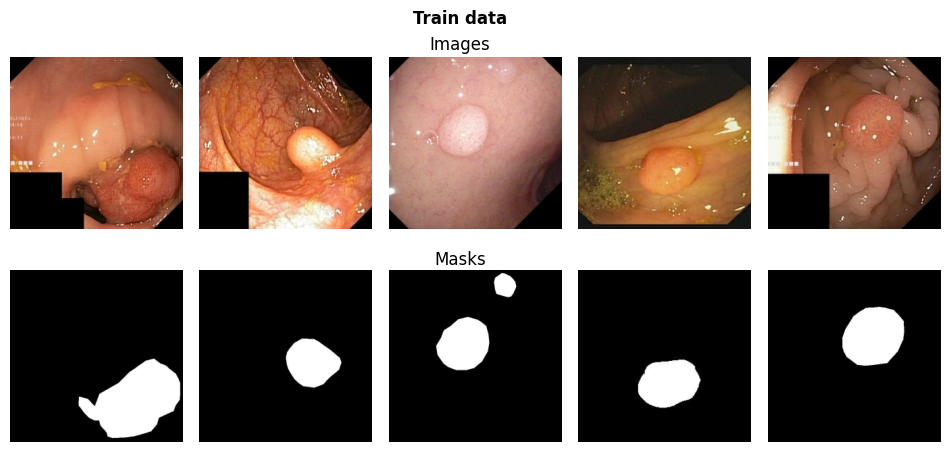


Minimum image pixel value: 0.0
Maximum image pixel value: 1.0
Minimum mask pixel value: 0.0
Maximum mask pixel value: 1.0


In [ ]:
dataset = train_dataset
split_name = "Train"
plot_images(dataset,split_name)

We can see that in the EDA notebook, the minimum and maximum pixel value of our image is (0, 255). After rescaling, the the minimum and maximum pixel value of our image is between 0 and 1.


<a name="validation-batches"></a>
#### Validation set

For validation set, the number of images is smaller as compared to train set as we have lesser samples in the validation set than in the train set.

Validation images
------------------------------
Number of samples: 185



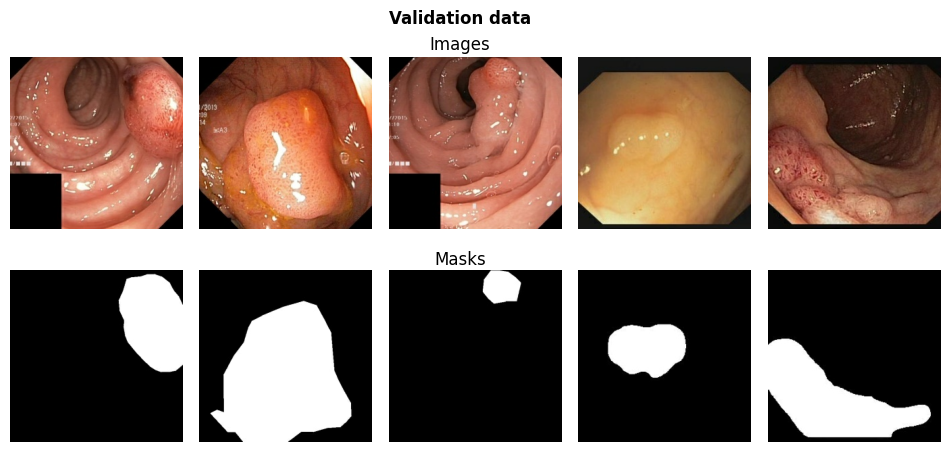


Minimum image pixel value: 0.0
Maximum image pixel value: 1.0
Minimum mask pixel value: 0.0
Maximum mask pixel value: 1.0


In [ ]:
dataset = valid_dataset
split_name = "Validation"
plot_images(dataset,split_name)

Same as the train set, after rescaling, the the minimum and maximum pixel value of our image data is between 0 and 1.

<a name="test-batch"></a>
#### Test batch

Test images
------------------------------
Number of samples: 189



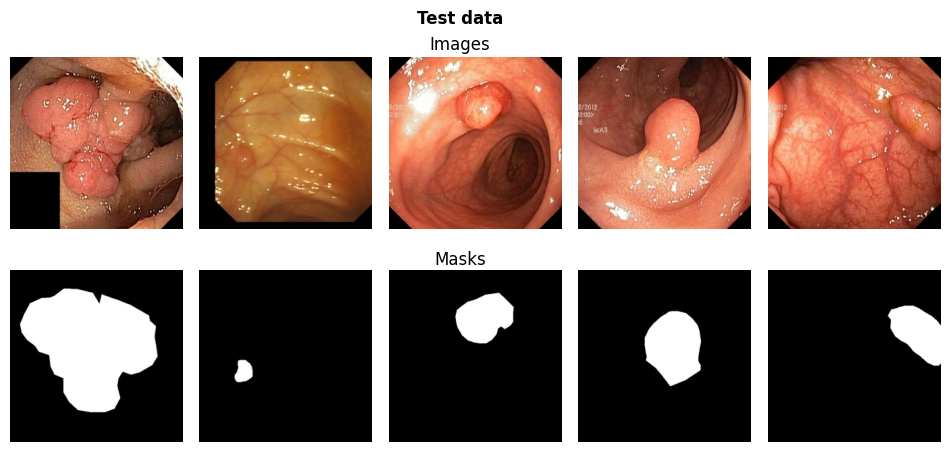


Minimum image pixel value: 0.0
Maximum image pixel value: 1.0
Minimum mask pixel value: 0.0
Maximum mask pixel value: 1.0


In [ ]:
dataset = test_dataset
split_name = "Test"
plot_images(dataset,split_name)

Same as the train set, after rescaling, the the minimum and maximum pixel value of our image data is between 0 and 1.

<a name="data-augmentation"></a>
### Data Augmentation

This process consists of randomly flipping the image both horizontally and vertically, randomly rotating the image up to 20% of a full rotation, and randomly zooming the image up to 20%. These augmentations improve the training data set by introducing variability, which helps to improve the robustness and generalization of the machine learning models.

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])


train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

<a name="vae-model"></a>
## Variational Autoenconder Model

A Variational Autoencoder (VAE) is a type of neural network model used for unsupervised learning of complex data representations. It learns to encode input data into a lower-dimensional latent space, where it captures the underlying structure of the data. Key components include an encoder, which maps input data to a probability distribution in the latent space, and a decoder, which reconstructs the original data from samples drawn from this distribution. VAEs are probabilistic models, enabling them to generate new data samples by sampling from the learned latent space distribution. They are valuable for tasks like image generation, text modeling, and data representation learning.

<a name="model-architecture"></a>
### Model architecture
The U-Net architecture can be visualized as a "U" shape, which gives it its name. Here's a breakdown of its structure:

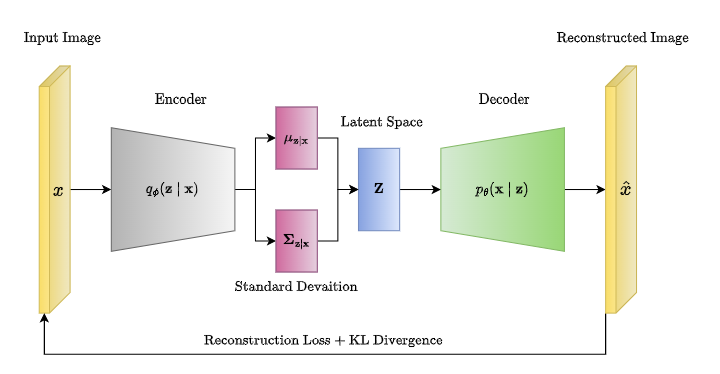

**Encoder**: Captures essential features and compresses input into latent variables (μ and σ).

**Latent Space**: Probabilistic space representing the compressed form of input, sampled via reparameterization.

**Decoder**: Reconstructs the input from the latent variable, upsampling through transposed convolutions.

**Output Layer**: Final layer reconstructs the input image, usually using a sigmoid or tanh activation.

**Loss Function**: Combination of reconstruction loss and KL divergence to ensure accurate reconstruction and smooth latent space.

In [ ]:
# Set seeds for reproducibility
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

<a name="model-configuration"></a>
### Model configuration

In this section, the VAE model will be configured for training. The functions build_encoder and build_decoder are executed with latent_dim as argument to build the encoder and decoder parts of the VAE, respectively. The encoder compresses the input data into the 128-dimensional latent space, while the decoder reconstructs the input data from the latent representation. The model will be trained for 100 epochs.

In [ ]:
latent_dim = 128
epochs = 100

encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0]

A Variational Autoencoder (VAE) model is created and compiled by first instantiating the VAE class with the previously constructed encoder and decoder. It then compiles the model using the Adam optimizer with a learning rate of 1e-4, specifying the mean squared error (MSE) as the loss function for the “reconstructed” output and a custom combined loss function for the “segmentation” output. This setup prepares the VAE model for training, defining how its performance will be optimized and evaluated.

In [ ]:
# Instance VAE class
model = VAE(encoder, decoder)

# Compile the model with the new loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss={'reconstructed': 'mse', 'segmentation': combined_loss})

<a name="model-training"></a>
### Model training

Once the model is successfully compiled, it is ready for training. The following are key points for setting up the training process correctly:

1. **Custom Callback for Metrics**: A custom callback is created to capture additional metrics during training, using *valid_dataset* for validation data.

2. **Model Checkpoint**: The `ModelCheckpoint` callback saves the model's weights at *./model/vae_weights.h5* whenever the validation loss improves, ensuring the best model is saved.

3. **Early Stopping**: The `EarlyStopping` callback monitors the validation loss and stops training if it doesn't improve for **10** consecutive epochs, restoring the best weights to prevent overfitting.

4. **Learning Rate Reduction**: The `ReduceLROnPlateau` callback reduces the learning rate by a factor of **0.1** if the validation loss plateaus for **8** epochs, with a minimum learning rate of **1e-5**, to aid model convergence.

5. **Class Weight Adjustment**: Class weights are set to handle class imbalance, calculated based on the ratio of the total number of samples to the number of samples in each class.

6. **Training**: The fit method trains the model on train_dataset for the specified number of epochs, using valid_dataset for validation. The class_weight parameter adjusts for class imbalance, and the training process is monitored by the specified callbacks (early_stopping and lr_schedule).



In [ ]:
# Custom callback for capturing metrics
custom_metrics_callback = CustomMetricsCallback(validation_data=valid_dataset)

# Set up callbacks for model checkpoints, early stopping, and learning rate reduction
checkpoint_path = './model/vae_weights.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-5)

class_weight = {0: 1.0, 1: 1.0 * (916905 / 131671)}
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=valid_dataset,
                  class_weight=class_weight,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), lr_schedule])

# Save the model architecture to a JSON file if needed
model_json = model.to_json()
with open("vae_model.json", "w") as json_file:
    json_file.write(model_json)


# Display the model's architecture
model.summary()

Epoch 1/100
58/58 [==============================] - 43s 332ms/step - loss: 4.6751 - reconstructed_loss: 0.6065 - segmentation_loss: 3.2425 - val_loss: 1.6944 - val_reconstructed_loss: 0.2387 - val_segmentation_loss: 1.4140 - lr: 1.0000e-04
Epoch 2/100
58/58 [==============================] - 16s 257ms/step - loss: 3.7021 - reconstructed_loss: 0.5200 - segmentation_loss: 2.9042 - val_loss: 1.6506 - val_reconstructed_loss: 0.2175 - val_segmentation_loss: 1.3654 - lr: 1.0000e-04
Epoch 3/100
58/58 [==============================] - 16s 252ms/step - loss: 3.4749 - reconstructed_loss: 0.4854 - segmentation_loss: 2.7551 - val_loss: 1.6845 - val_reconstructed_loss: 0.2070 - val_segmentation_loss: 1.3438 - lr: 1.0000e-04
Epoch 4/100
58/58 [==============================] - 17s 273ms/step - loss: 3.4044 - reconstructed_loss: 0.4718 - segmentation_loss: 2.6830 - val_loss: 1.6582 - val_reconstructed_loss: 0.2018 - val_segmentation_loss: 1.3323 - lr: 1.0000e-04
Epoch 5/100
58/58 [=================

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 128),             9961408   
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 decoder (Functional)        [(None, 256, 256, 3),     3098100   
                              (None, 256, 256, 1)]               
                                                                 
Total params: 13059508 (49.82 MB)
Trainable params: 13056532 (49.81 MB)
Non-trainable params: 2976 (11.62 KB)
_________________________________________________________________


When the training is completed, the `fit` method will return a **History** object, which is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values.

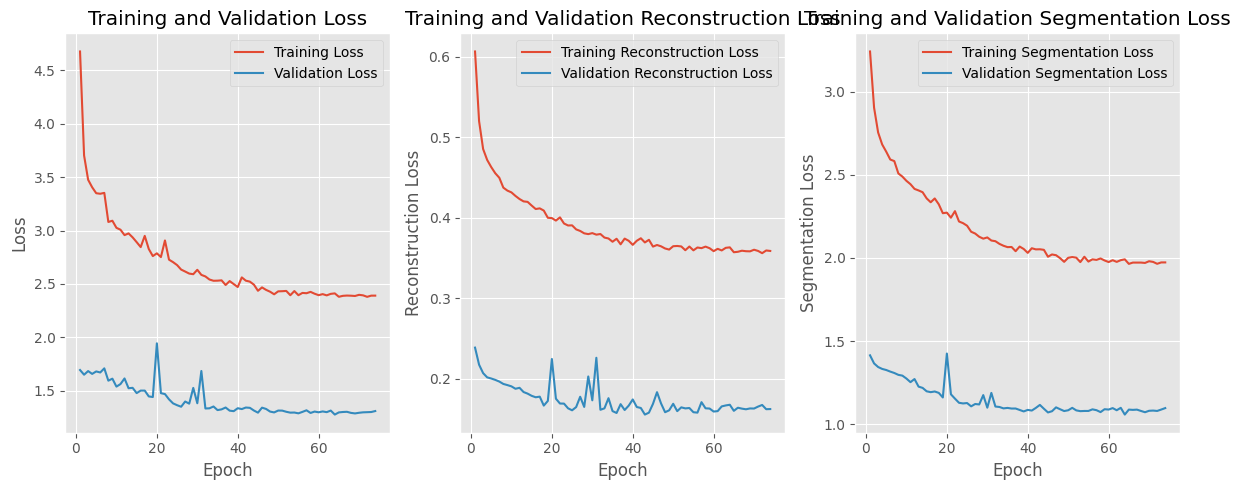

In [ ]:
# Get the history of accuracy and loss from the `history` object
loss = history.history['loss']
val_loss = history.history['val_loss']
reconstructed_loss = history.history['reconstructed_loss']
val_reconstructed_loss = history.history['val_reconstructed_loss']
segmentation_loss = history.history['segmentation_loss']
val_segmentation_loss = history.history['val_segmentation_loss']

# Plot the loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the loss
plt.subplot(1, 3, 2)
plt.plot(range(1, len(reconstructed_loss) + 1), reconstructed_loss, label='Training Reconstruction Loss')
plt.plot(range(1, len(val_reconstructed_loss) + 1), val_reconstructed_loss, label='Validation Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Training and Validation Reconstruction Loss')
plt.legend()

# Plot the loss
plt.subplot(1, 3, 3)
plt.plot(range(1, len(segmentation_loss) + 1), segmentation_loss, label='Training Segmentation Loss')
plt.plot(range(1, len(val_segmentation_loss) + 1), val_segmentation_loss, label='Validation Segmentation Loss')
plt.xlabel('Epoch')
plt.ylabel('Segmentation Loss')
plt.title('Training and Validation Segmentation Loss')
plt.legend()

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

The following conclusions can be drawn from the training history:
- Overall loss: the total loss calculated on the training data for each epoch encompasses all the individual loss components defined in the model. In the figure, both training and validation lines decrease over the epochs, indicating that the model is learning from the training data and is able to generalize this learning to the validation data.
- Reconstruction loss: this plot shows the reconstruction loss, which measures the ability of the VAE to reconstruct the input data after encoding and decoding. Both lines are steadily decreasing, which means that VAE reconstructions are becoming more and more accurate.
- Segmentation loss: Segmentation loss refers to a task-specific loss. Decreasing segmentation loss suggests better performance on the segmentation task.

Overall, the model shows good performance, with robust validation metrics and no immediate signs of overfitting. 'Re-constructed_loss' and 'Segmentation_loss' are the individual components of the total loss and are used to understand the behavior of the model and diagnose potential problems.

For all three loss types a lag between the training and validation lines is observed, which is not too large and relatively stable. Therefore, in the next section we will consider other metrics better suited to assess segmentation performance.

<a name="model-evaluation"></a>
### Model evaluation

Other than accuracy, the other metrics that are often used in evaluating segmentation performance are:
- Precision
- Recall
- IoU (Intersection over Union)
- Dice Coefficient


<a name="confusion-matrix"></a>
#### Confusion matrix

All presented metrics above are based on the computation of a **confusion matrix**, which represent the number of pixels that were correctly or incorrectly classified as either the object of interest or the background.

1/1 [==============================] - 0s 373ms/step
Confusion Matrix:
 [[842628   9929]
 [158731  37288]]


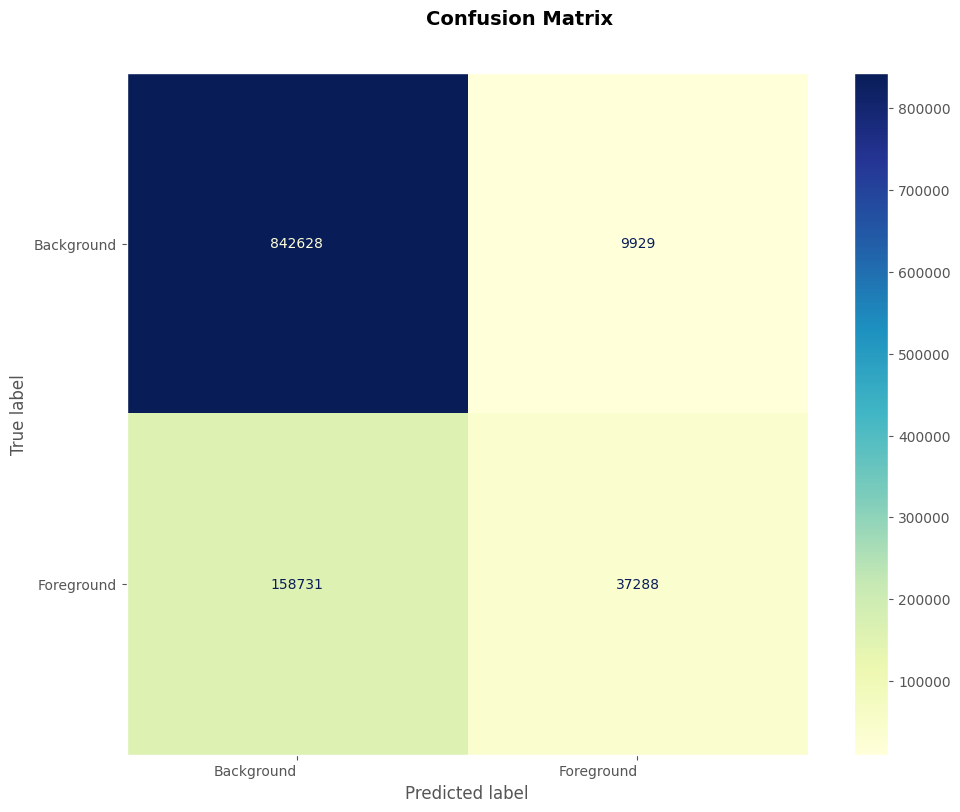

In [ ]:
# Evaluate on test data
test_images, test_masks = next(iter(test_dataset))
predictions = model.predict(test_images)
reconstructed_images, segmentations = predictions['reconstructed'], predictions['segmentation']

# Convert to binary masks
test_masks_binary = tf.cast(test_masks > 0.5, dtype=tf.float32)
segmentations_binary = tf.cast(segmentations > 0.5, dtype=tf.float32)

# Flatten the binary masks
test_masks_flat = tf.reshape(test_masks_binary, [-1])
segmentations_flat = tf.reshape(segmentations_binary, [-1])

class_names = ["Background", "Foreground"]

# Confusion Matrix
conf_matrix = confusion_matrix(test_masks_flat, segmentations_flat)
print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix
fig, axes = plt.subplots(figsize=(10,8))
plt.tight_layout()
plt.subplots_adjust(top=0.9)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.YlGnBu, ax=axes)
disp.ax_.grid(False)

plt.setp(disp.ax_.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=10)
plt.setp(disp.ax_.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=10)
disp.figure_.suptitle("Confusion Matrix", fontsize=14, weight='bold')

plt.show()


From the confusion matrix, we can observe that:
- **True Positive (TP):** 37,288 pixels were correctly identified as the object of interest.
- **True Negative (TN):** 842,628 pixels were correctly identified as the background.
- **False Positive (FP):** 9,929 pixels were incorrectly identified as the object of interest.
- **False Negative (FN):** 158,731 pixels were incorrectly identified as the background.

<a name="classification-report"></a>
#### Classification report


It is posible to use the values from the confusion matrix (TP, TN, FP, and FN) to calculate evaluation metrics such as precision, recall, IoU, and dice coefficient, which provide a comprehensive assessment of the model's segmentation performance.

In [ ]:


# Classification Report
class_report = classification_report(test_masks_flat, segmentations_flat, target_names=class_names)
print("Classification Report:\n", class_report)



Classification Report:
               precision    recall  f1-score   support

  Background       0.84      0.99      0.91    852557
  Foreground       0.79      0.19      0.31    196019

    accuracy                           0.84   1048576
   macro avg       0.82      0.59      0.61   1048576
weighted avg       0.83      0.84      0.80   1048576



The classification report illustrates a notable contrast in the performance of the variational autoencoder between background and foreground classes. While achieving an overall accuracy of 84%, the model exhibits strong precision and recall for the background class (0.84 and 0.99, respectively), indicating robust identification of background instances. In contrast, the foreground class shows lower precision (0.79) and recall (0.19), resulting in a substantially lower F1-score (0.31), highlighting challenges in correctly identifying foreground instances. Consequently, the macro average F1-score is moderate at 0.61, reflecting the imbalanced performance between classes, with the weighted average F1-score (0.80) influenced by the larger number of background samples.

<a name="iou-and-dice-coefficient-(f1-score)"></a>
#### IoU and Dice coefficient (F1 score)

F-measure, also called F-score, is one of the most widespread scores for performance measuring in MIS (Medical Image Segmentation). Based on the F-measure, there are two popular utilized metrics in MIS:
- Intersection over Union (IoU)
- Dice coefficient

**Intersection over Union (IoU)**, also known as *Jaccard index*, is the area of the intersection over union of the predicted segmentation and the ground truth.
$$
IoU = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}
$$
<br>

**Dice coefficient = F1-score**, is the harmonic mean of precision and recall. In another words, dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images
$$
Dice = \frac{2 \times \text{TP}}{2 \times \text{TP} + \text{FP} + \text{FN}}
$$
<br>


<a name="iou-and-dice-coefficient"></a>
#### IoU and Dice Coefficient

In [ ]:
# Initialize variables to store the total intersection, union, and sums for Dice coefficient
total_intersection = 0
total_union = 0
total_dice_numerator = 0
total_dice_denominator = 0

# Get the total number of samples in the test set
num_samples = len(list(test_dataset))

# Compute Intersection over Union (IoU) and Dice coefficient for each batch in the test set
for batch_images, batch_masks in test_dataset:
    # Generate predictions for the batch
    batch_predictions = model.predict(batch_images, verbose=0)['segmentation']

    # Threshold the predictions to obtain binary masks
    binary_predictions = (batch_predictions > 0.5).astype(np.uint8)

    # Compute intersection and union for the batch
    intersection = np.logical_and(batch_masks.numpy(), binary_predictions)
    union = np.logical_or(batch_masks.numpy(), binary_predictions)

    # Compute Dice coefficient for the batch
    dice_numerator, dice_denominator = dice_coefficient(batch_masks.numpy(), binary_predictions)

    # Update the totals
    total_intersection += np.sum(intersection)
    total_union += np.sum(union)
    total_dice_numerator += dice_numerator
    total_dice_denominator += dice_denominator

# Compute the mean IoU and Dice coefficient across all batches
mean_iou = total_intersection / total_union
mean_dice = total_dice_numerator / total_dice_denominator

# Print the mean IoU and Dice coefficient
print(f"Mean IoU: {mean_iou}")
print(f"Mean Dice Coefficient: {mean_dice}")


Mean IoU: 0.19637979073709644
Mean Dice Coefficient: 0.3327503566899089


The segmentation model's performance, as evaluated by the mean Intersection over Union (IoU) of 0.196 and mean Dice coefficient of 0.333, indicates a moderate level of accuracy in delineating polyps in medical images. While these results suggest some success in capturing the spatial overlap and correspondence between predicted and ground truth masks, there remains room for improvement to achieve higher precision and consistency in segmentation.

<a name="reconstructed-image"></a>
### Reconstructed image (decoder output)

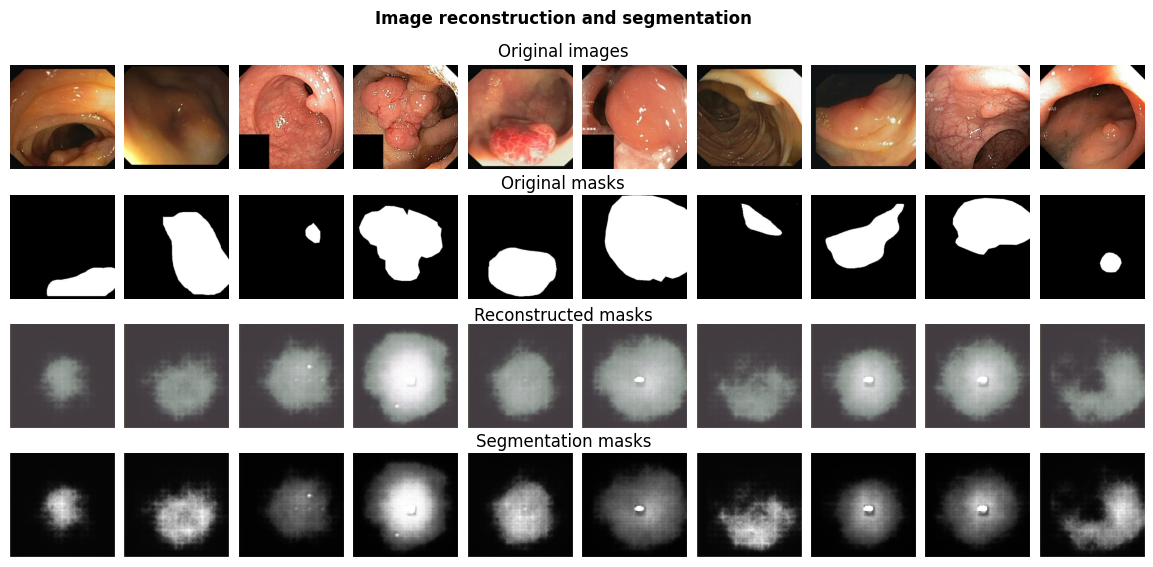

In [ ]:
original = test_images.numpy()
ground_t = test_masks.numpy()
reconstructed = reconstructed_images
segmentation = segmentations

fig, axes = plt.subplots(4,10, figsize = (12,6))
plt.tight_layout()

for i in range(10):
  # Original image
  axes[0,i].imshow(original[i])
  axes[0,i].axis('off')

  # Original mask
  axes[1,i].imshow(ground_t[i], cmap = "gray")
  axes[1,i].axis('off')

  # Reconstructed image
  axes[2,i].imshow(reconstructed[i])
  axes[2,i].axis('off')

  # Segmentation mask
  axes[3,i].imshow(segmentation[i, :, :, 0], cmap = "gray")
  axes[3,i].axis('off')

fig.suptitle("Image reconstruction and segmentation", fontweight = 'bold')
plt.subplots_adjust(top=0.89, wspace=0.1, hspace= 0.2)
plt.figtext(0.5, 0.91, "Original images", va="center", ha="center", size=12)
plt.figtext(0.5, 0.69, "Original masks", va="center", ha="center", size=12)
plt.figtext(0.5, 0.47, "Reconstructed masks", va="center", ha="center", size=12)
plt.figtext(0.5, 0.26, "Segmentation masks", va="center", ha="center", size=12)
plt.plot();


<a name="mask-prediction"></a>
### Mask prediction

Four evaluation metrics—precision, recall, IoU, and dice coefficient—have been investigated to assess the model's effectiveness in segmenting polyps. To gain a comprehensive view of the model's performance, a qualitative assessment through visual inspections can now be conducted.

Random indices: [1, 4, 15, 12, 6]


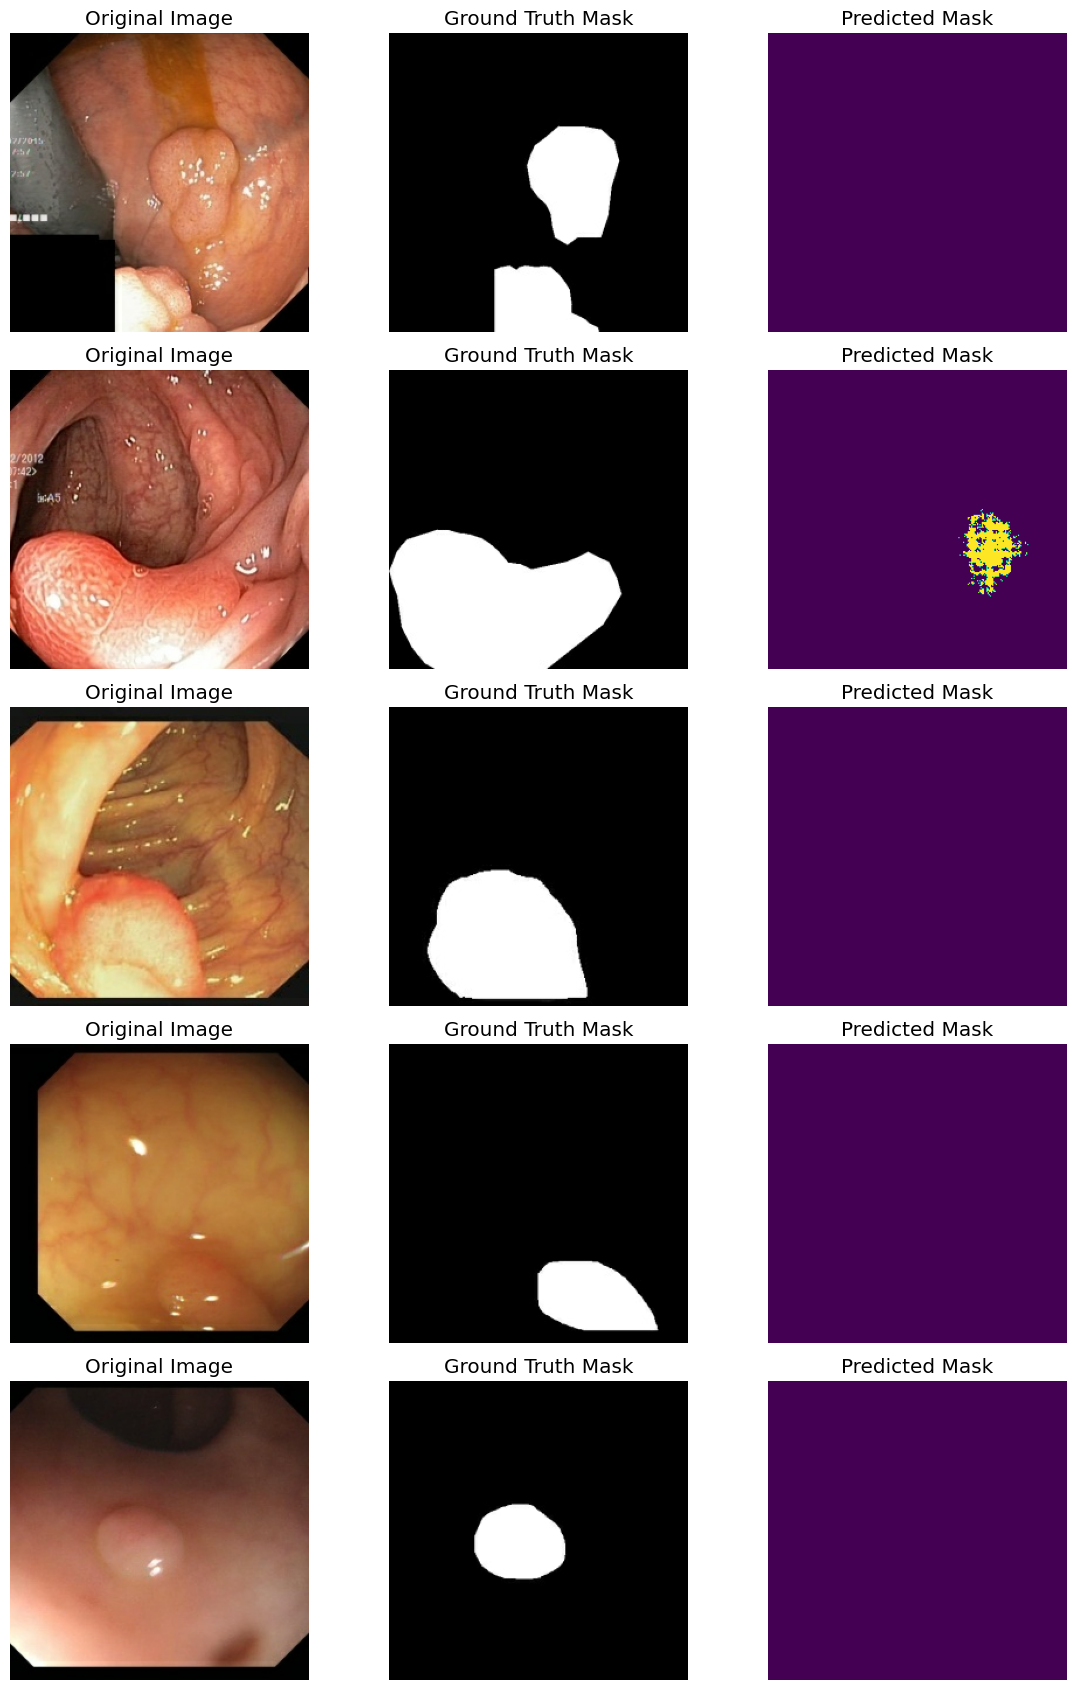

In [ ]:
# Fix the seed for reproducibility
random.seed(123)

# Get the corresponding test image and mask (from only 1 batch)
test_batch = next(iter(test_dataset))
test_images, test_masks = test_batch

# Get a random index to select 5 samples from the test batch
random_indices = random.sample(range(len(test_images)), 5)

# Generate predictions for the test images
predictions = model.predict(test_images, verbose=0)['segmentation']

# Threshold the prediction to obtain the binary mask
binary_predictions = (predictions > 0.5).astype(np.uint8)

# Print random indices
print(f"Random indices: {random_indices}")

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(test_images[random_index])
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(test_masks[random_index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(binary_predictions[random_index], cmap='viridis')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


The VAE segmentation model shows low capabilities in capturing the morphology of polyp regions, as indicated by its moderate mean IoU of 0.196 and mean Dice coefficient of 0.333. Inconsistencies in segmentation suggest refining spatial accuracy. Adjusting the prediction threshold to mitigate false positives while maintaining sensitivity to true positives is crucial, requiring careful consideration to strike a balance between accuracy and sensitivity.

<a name="conclusion"></a>
### Conclusion

The model exhibits strong classification accuracy, particularly in identifying background regions, with an impressive precision of 84% and recall of 99%. However, its performance in detecting foreground (polyp) regions shows room for improvement, with a recall rate of only 19%. While achieving a moderate mean IoU of 0.196 and mean Dice coefficient of 0.333, indicating fair spatial agreement with ground truth masks, enhancing boundary delineation and overall segmentation accuracy remains a priority. Striking a balance between precision and recall is crucial for reliable polyp detection, necessitating careful threshold adjustments to minimize false positives without compromising sensitivity to true positives. Continuous refinement, informed by clinical expertise, is essential to optimize the model's effectiveness in polyp identification and segmentation tasks.